## Clustering Covid-19 time series

## Please do view the Notebook here:  
**https://nbviewer.jupyter.org/github/rbiele02/07_clustering_covid_time_series/blob/master/covid_clustering.ipynb**  
Folium maps can't be displayed on Github.

**Questions**:
- Which **countries are affected the most**? How to measure it? 
- Can we **find structure/patterns** in the data?

**Data from the Johns Hopkins University (https://coronavirus.jhu.edu/map.html).**
This page is really slow and only allows limited comparison. So let's import them.

In [1]:
# this imports all needed functions and also the data from the JHU
# details can be found in the file modules.py
from modules_covid import *

# for plotting:
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.dpi'] = 90.

/Users/robertb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


The data is from 13/09/2020.


Let us plot the top 15 countries of confirmed infections.

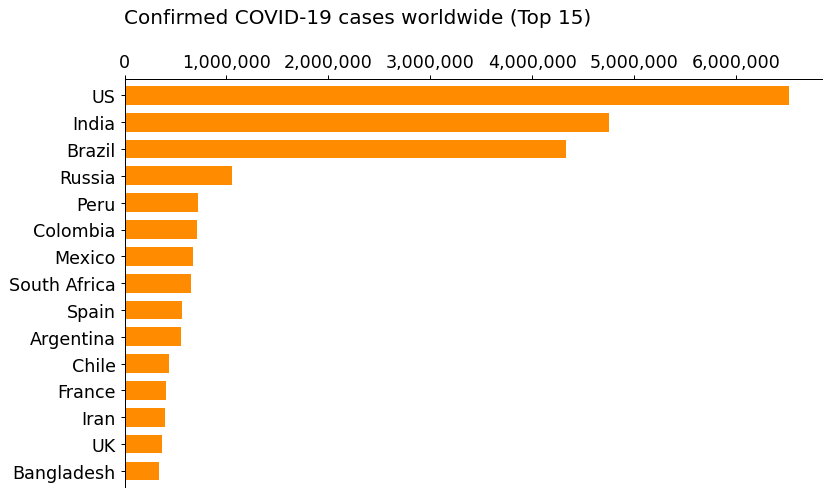

In [2]:
ax = cases.iloc[:, -1].head(15).plot(kind='barh',
                                     figsize=(10, 6),
                                     width=0.7,
                                     color='darkorange')
ax.set_title('Confirmed COVID-19 cases worldwide (Top 15)\n', fontsize=16,loc='left')
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().invert_yaxis()
ax.xaxis.tick_top();

**Difficult to compare countries with different size and population.**

### So let's normalize to population

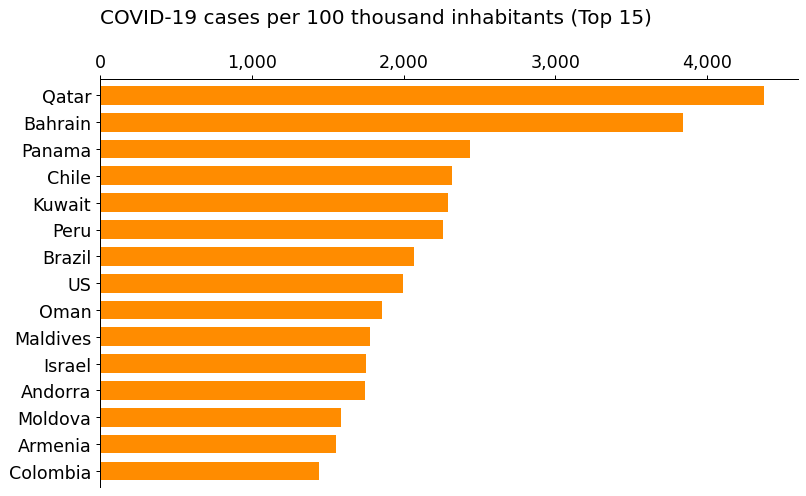

In [3]:
ax = cases_pT.iloc[:, -1].head(15).plot(kind='barh',
                                        figsize=(10, 6),
                                        width=0.7,
                                        color='darkorange')
ax.set_title('COVID-19 cases per 100 thousand inhabitants (Top 15)\n', fontsize=16, loc='left')
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().invert_yaxis()
ax.xaxis.tick_top();

**What about the testing rate?** There might be much more cases in some countries; due to poor testing rate those might be uncounted. A better measure would be the number of deaths normalized to populations.

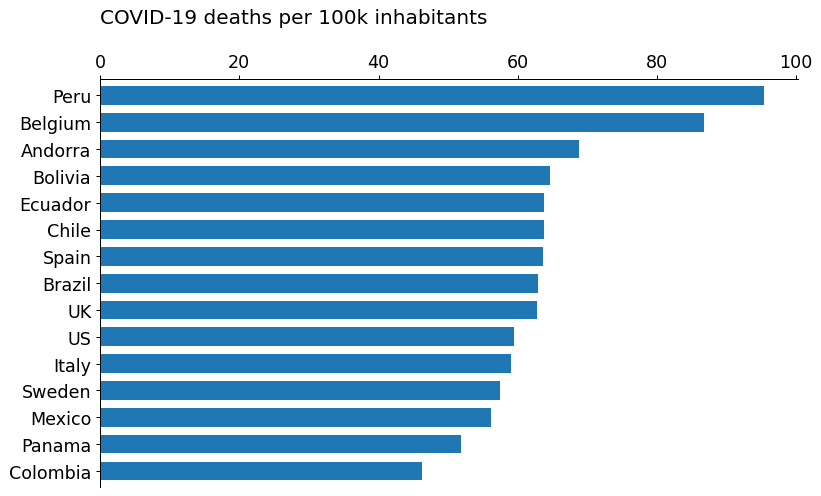

In [4]:
deaths_pT.sort_values([last_day], ascending=False, axis=0, inplace=True)

ax = deaths_pT.iloc[:, -1].sort_values(ascending=False).head(15).plot(kind='barh',
                                         figsize=(10, 6),
                                         width=0.7)
ax.set_title('COVID-19 deaths per 100k inhabitants\n', fontsize=16, loc='left')
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().invert_yaxis()
ax.xaxis.tick_top();

Let us next take a look at the dynamical behavior of daily COVID-19 deaths. 

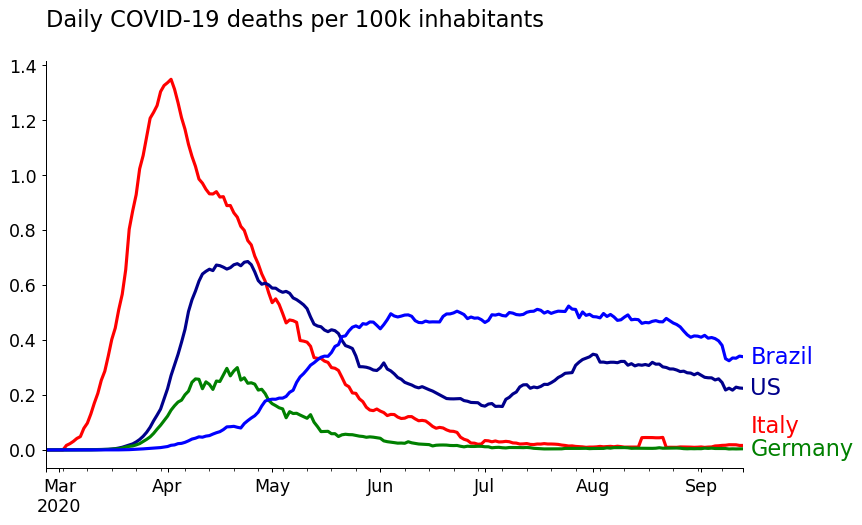

In [5]:
countries = ['Italy', 'US','Germany','Brazil']
delay_days = 35
colors = ['red', 'darkblue', 'green','blue']
fig, ax2 = plt.subplots()
for country, col in zip(countries, colors):
    deaths_pT_new.loc[country][delay_days:].rolling(7).mean().fillna(
        0).plot(kind='line',
                linewidth=2.5,
                label=country,
                figsize=(10, 6),
                color=col, ax=ax2)
ax2.set_title('Daily COVID-19 deaths per 100k inhabitants\n', fontsize=18, loc='left')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
for line, name, sett in zip(ax2.lines, countries, [0.07, 0, 0.0,0.0,0.0]):
    y = line.get_ydata()[-1]
    ax2.annotate(name,
                 xy=(1, y + sett),
                 xytext=(6, 0),
                 color=line.get_color(),
                 xycoords=ax2.get_yaxis_transform(),
                 textcoords="offset points",
                 size=18,
                 va="center")

We see that there are different characteristics in those curves:
- some countries have a high number of deaths in the first COVID-19 'wave' but then they managed to go back to normality
- other countries are constantly suffering COVID-19 deaths over the time
- ...  

In the next sections we will apply a ML clustering technique to find out of all the 184 daily deaths curves, 3 categories.

### Finding structure: ML Cluster 184 countries -- deaths per inhabitants 

**If we ask our clustering algorithm to divide all curves into three categories, what 3 main types of curves will be found? How will those be distributed over the world? Is there any structure?**

COVID-19 deaths vs time curves
3.532 --> 2.646 --> 2.571 --> 2.529 --> 2.506 --> 2.500 --> 2.500 --> 
green cluster, N = 158
red cluster, N = 9
blue cluster, N = 16


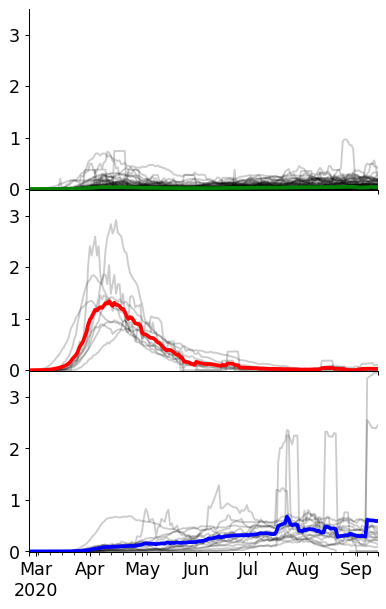

In [6]:
from tslearn.utils import to_time_series_dataset
cluster = 3
df = deaths_pT_new.iloc[:,35:]
X_train = df.rolling(7, axis=1, min_periods=1).mean().fillna(0)
colors = ['blue', 'red', 'green']
names = ['blue cluster','red cluster','green cluster']
seed = 1
np.random.seed(seed)
X_train = to_time_series_dataset(X_train.copy())

print('COVID-19 deaths vs time curves')
km = TimeSeriesKMeans(n_clusters=cluster, verbose=True, random_state=seed,
                         max_iter=10)

y_pred = km.fit_predict(X_train)
clusters = pd.Series(data=y_pred, index=df.index)

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(5, 8))

for yi,cl,xs in zip(range(cluster),[2,1,0],[ax1,ax2,ax3]):
    data = df.rolling(7, axis=1, min_periods=1).mean().fillna(0).loc[clusters[clusters == cl].index]
    data.T.plot(legend=False, alpha=.2,color='black', ax=xs)
    data.mean(axis=0).plot(linewidth=3., color=colors[cl], ax=xs)
    n = len(data)
    print('{}, N = {}'.format(names[cl], n))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['right'].set_visible(False)

f.subplots_adjust(hspace=0)
plt.ylim(-0.02, 3.5)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

So we find three clusters:
- green: 158 countries with a  low number of deaths over time, always returning close to zero
- red: too much deaths at the first wave, but now returned to normality (9 countries)
- blue: countries that have a raising number of deaths over the time.

**How these clusters are distributed  over the world?**

In [7]:
world = Map(tiles='cartodbpositron')
from IPython.display import IFrame
opa = [0.99,0.99,0.5]
for name in coord.index:
    CircleMarker([coord.loc[name].lat, coord.loc[name].long],
                 popup=Popup(max_width=450).add_child(
                     Vega(coord.loc[name].json, width=450, height=250)),
                 color=colors[clusters.loc[name]],
                 radius=5,
                 fill=True,
                 opacity=opa[clusters.loc[name]]).add_to(world)
world